In [4]:
import pandas as pd
import pickle
import tqdm

In [5]:
with open("all_notes_with_quickumls_results.pkl", "rb") as f:
    quick_umls_results = pickle.load(f)

In [6]:
dream = pd.read_csv("dreamdnpto.csv")
print(len(dream))

#filter out ones without umls_cui
dream = dream[dream["umls_cui"].notnull()]
print(len(dream))

#get a list of all the unique umls_cui
umls_cui = dream["umls_cui"].unique()
len(umls_cui)

300
126


126

In [7]:
#keep only records that have at least one cui in the umls_cuis from the ontology: 9465, but not all preferred

quick_umls_results_filtered = [] 
added_admission_ids = []

for record in tqdm.tqdm(quick_umls_results):
    for res in record["matched_results"]:
        for item in res:
            if item["cui"] in umls_cui:
                if record["hadm_id"] not in added_admission_ids:
                    quick_umls_results_filtered.append(record)
                    added_admission_ids.append(record["hadm_id"])
                break;


len(quick_umls_results_filtered)

100%|██████████| 14953/14953 [01:13<00:00, 204.02it/s]


9465

In [8]:
#go through the subjects and keep only the ones that have at least one preferred cui
all_matched_therapies_by_subject = []

for subject in tqdm.tqdm(quick_umls_results):
    subject_edited = {
        "subject_id": subject["subject_id"],
        "hadm_id": subject["hadm_id"],
        "cui_matched": []
    }
    
    for res in subject["matched_results"]:
        for term in res:
            if term["cui"] in umls_cui and term.get("preferred") == 1:
                subject_edited["cui_matched"].append({
                    "cui": term["cui"],
                    "term": term["term"],
                    "ngram": term["ngram"]
                })

    if subject_edited["cui_matched"]:
        all_matched_therapies_by_subject.append(subject_edited)

print(len(all_matched_therapies_by_subject))



100%|██████████| 14953/14953 [01:05<00:00, 227.54it/s]

7348


## get summary on number of subjects/admissions

In [49]:
#get unique number of subjects and admissions id
subjects_with_non_pharmcological = []
subjects_admissions_with_non_pharmcological = []
for subject in all_matched_therapies_by_subject:
    subjects_with_non_pharmcological.append(int(subject["subject_id"]))
    subjects_admissions_with_non_pharmcological.append((int(subject["subject_id"]), int(subject["hadm_id"])))


#get unique values
subjects_with_non_pharmcological = list(set(subjects_with_non_pharmcological))
subjects_admissions_with_non_pharmcological = list(set(subjects_admissions_with_non_pharmcological))

len(subjects_with_non_pharmcological), len(subjects_admissions_with_non_pharmcological)


(5419, 7348)

In [50]:
#save to json
import json


with open("subjects_with_non_pharmcological.txt", "w") as f:
    json.dump(subjects_with_non_pharmcological, f)

with open("subjects_admissions_with_non_pharmcological.json", "w") as f:
    json.dump(subjects_admissions_with_non_pharmcological, f)

## save subjects and admissions information in original dreamdnpto csv file

In [51]:
#add list of matched subjects to dreamdnpto
dream["matched_subjects(subject_id, hadm_id)"] = None
dream["num_matched_subjects"] = 0


for index, row in tqdm.tqdm(dream.iterrows()):
    cui = row["umls_cui"]
    matched_subjects = [
        (subject["subject_id"], subject["hadm_id"])
        for subject in all_matched_therapies_by_subject
        if any(entry["cui"] == cui for entry in subject["cui_matched"])
    ]
    
    dream.at[index, "matched_subjects(subject_id, hadm_id)"] = matched_subjects if matched_subjects else []
    dream.at[index, "num_matched_subjects"] = len(matched_subjects)

len(dream)


30it [00:00, 89.88it/s]


30

In [ ]:
#unneeded column
dream = dream.drop(columns=["matched_subjects"])
dream.head(10)

In [28]:
#saving
dream.to_csv("dreamdnpto_with_matched_subjects.csv", index=False)

## get ontological information

In [53]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
#continued analysis
dream = pd.read_csv("dreamdnpto_with_matched_subjects.csv")
len(dream)

dream = dream[dream["num_matched_subjects"] > 0]
len(dream)

30

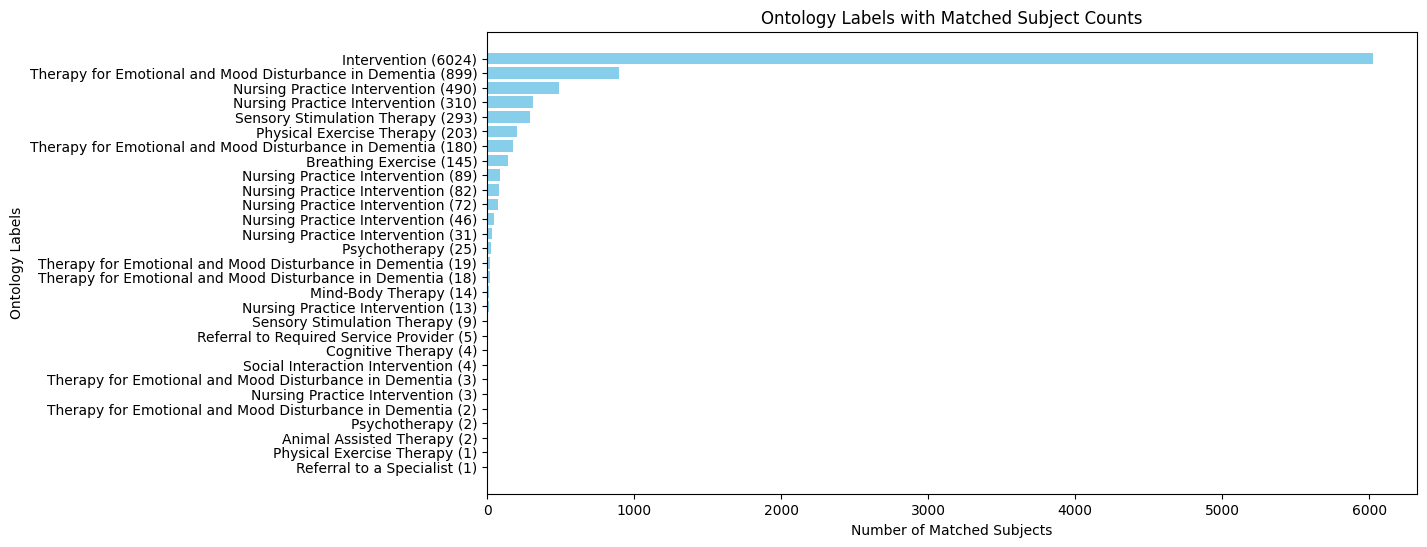

In [ ]:
#plot bar graph

ontology_df_filtered = dream[["parent_label", "num_matched_subjects"]]
ontology_df_filtered = ontology_df_filtered.sort_values(by="num_matched_subjects", ascending=False)
ontology_df_filtered["label_with_count"] = ontology_df_filtered["parent_label"] + " (" + ontology_df_filtered["num_matched_subjects"].astype(str) + ")"

#plotting
plt.figure(figsize=(12, 6))
plt.barh(ontology_df_filtered["label_with_count"], ontology_df_filtered["num_matched_subjects"], color='skyblue')
plt.xlabel("Number of Matched Subjects")
plt.ylabel("Ontology Labels")
plt.title("Ontology Labels with Matched Subject Counts")
plt.gca().invert_yaxis()
plt.show()

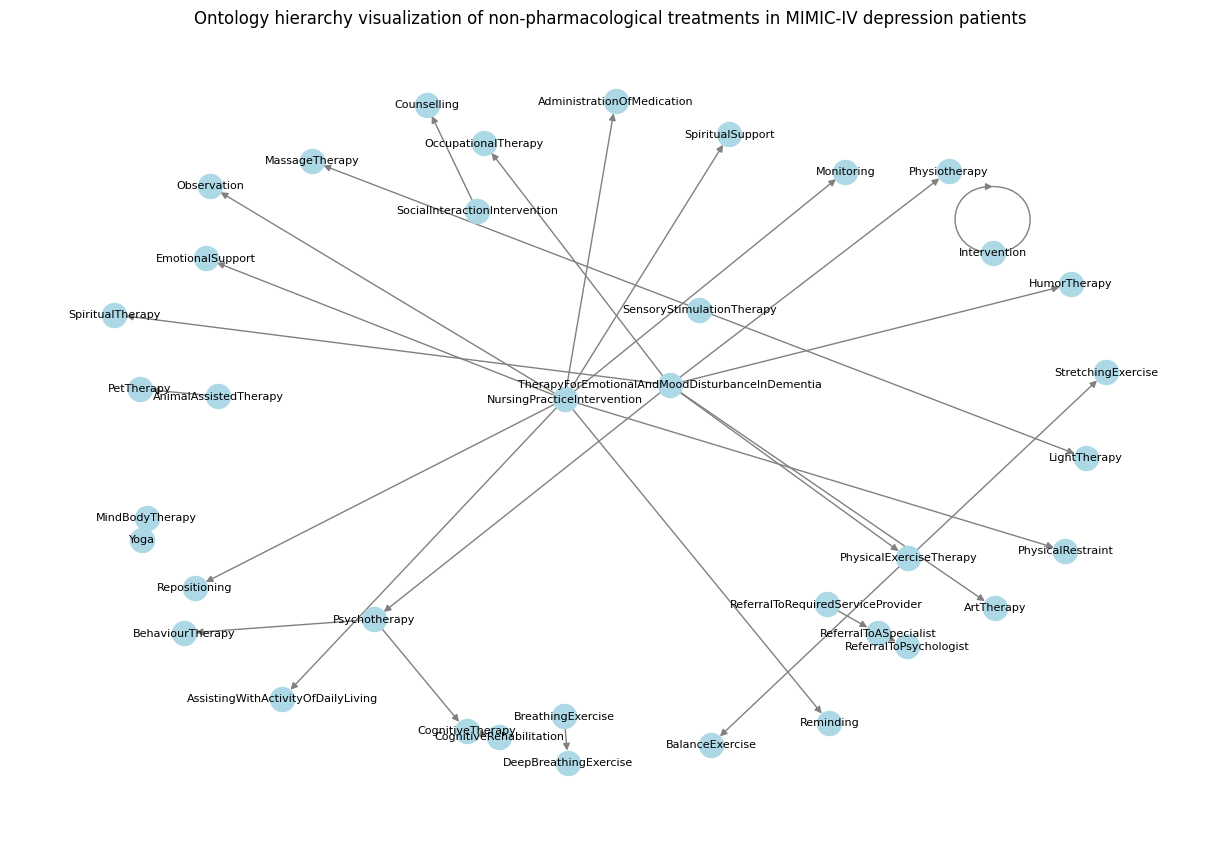

In [56]:
#directed graph
G = nx.DiGraph()
labels = {}

for index, row in dream.iterrows():
    parent = row["parent_id"]
    child = row["intervention_id"] if "intervention_id" in row else row["parent_id"]
    
    G.add_node(child)
    labels[child] = row["intervention_label"] 
    
    if pd.notna(parent):
        G.add_edge(parent, child)

#position
pos = nx.spring_layout(G, seed=42)  # Layout for better readability

#plotting
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=8)
plt.title("Ontology hierarchy visualization of non-pharmacological treatments in MIMIC-IV depression patients")
plt.show()


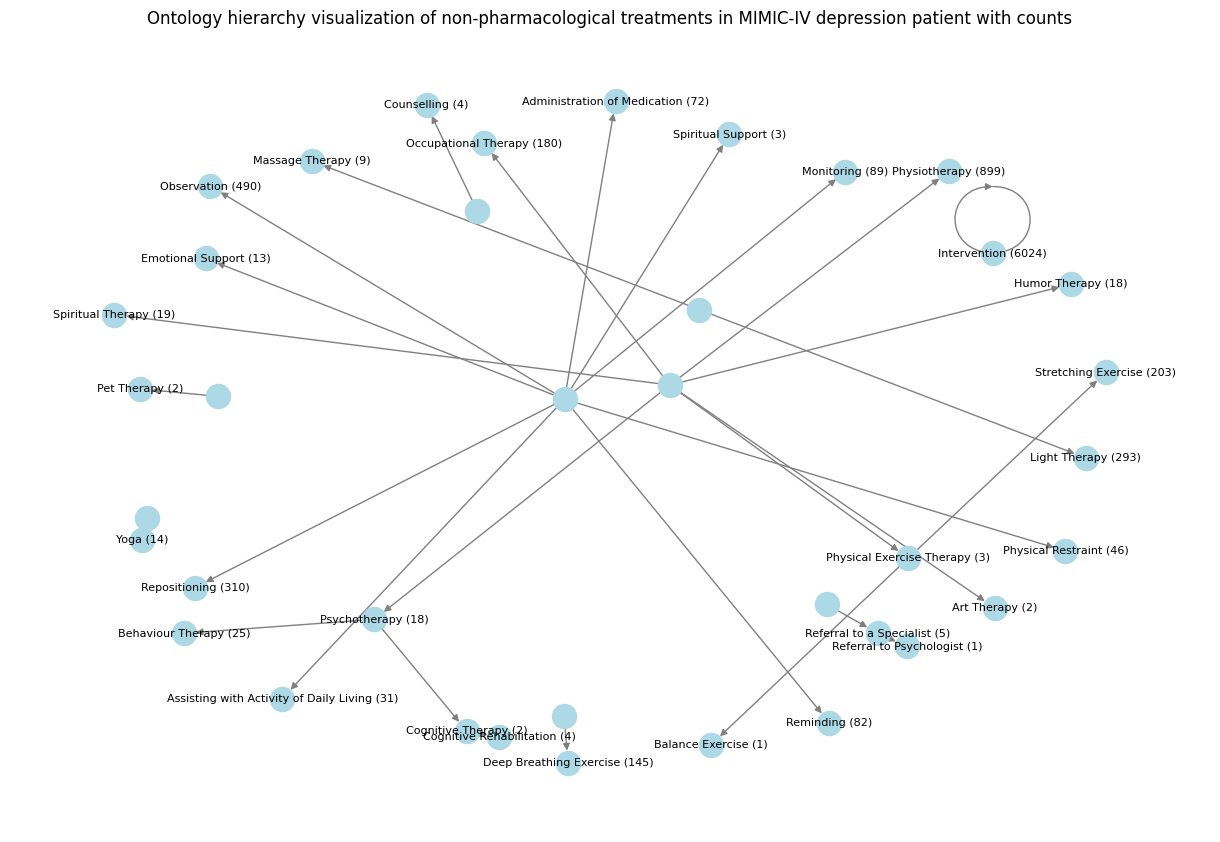

In [59]:
G = nx.DiGraph()
labels = {}


for index, row in dream.iterrows():
    parent = row["parent_id"]
    child = row["intervention_id"] if "intervention_id" in row else row["parent_id"]
    
    G.add_node(child)
    
    #counts
    count = row["num_matched_subjects"] if "num_matched_subjects" in row else 0
    labels[child] = f"{row['intervention_label']} ({count})"
    
    if pd.notna(parent):
        G.add_edge(parent, child)

#positions
pos = nx.spring_layout(G, seed=42)

#plotting
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_color="lightblue", edge_color="gray", font_size=8)
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color="black")

plt.title("Ontology hierarchy visualization of non-pharmacological treatments in MIMIC-IV depression patient with counts")
plt.show()
